<a href="https://colab.research.google.com/github/DyatlovaA/cv-tf/blob/main/%22%D0%9F%D0%A02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

# Шаг 1: Загрузка и предобработка данных

Если изображение не 224х224, то преобразуем его

Добавления шума

Загрузка и предобработка изображений

# Шаг 2: Создание автокодировщика

Кодировщик

Определение входного слоя

Сверточные слои и MaxPooling

Создание модели и вывод архитектуры

Латентное представление

Декодировщик


Создание моделей кодировщика и декодировщика

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
pip install kaggle

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Dropout, BatchNormalization, Conv2DTranspose, GlobalAveragePooling2D, ReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from glob import glob
import math

In [ ]:
# Параметры
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
NOISE_FACTOR = 0.4
EPOCHS = 20
#DATA_DIR = '/content/flower_photos/roses'  # Укажите путь к папке с изображениями
DATA_DIR = '//content/data/raw-img/gatto'

In [ ]:
from google.colab import files
uploaded = files.upload()
import zipfile
with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Saving archive (1).zip to archive (1).zip


In [ ]:
class MyDatasetSequence(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, img_size, noise_factor):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.noise_factor = noise_factor
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        images = np.array([self._load_image(self.image_paths[i]) for i in batch_indexes])
        noisy_images = self.add_gaussian_noise(images)
        return noisy_images.astype(np.float32), images.astype(np.float32)

    def _load_image(self, path):
        img = load_img(path)
        if img.size != (self.img_size[1], self.img_size[0]):
            img = img.resize((self.img_size[1], self.img_size[0]))
        return img_to_array(img) / 255.0

    def add_gaussian_noise(self, images):
        noise = np.random.normal(loc=0, scale=self.noise_factor, size=images.shape)
        return np.clip(images + noise, 0., 1.)


In [ ]:
class MyDataset:
    def __init__(self, image_path, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH),
                 noise_factor=NOISE_FACTOR, train_split=0.7, valid_split=0.2, test_split=0.1):
        assert math.isclose(train_split + valid_split + test_split, 1.0), "Сумма долей должна быть 1"

        self.image_paths = glob(os.path.join(image_path, '*.jpg')) + \
                         glob(os.path.join(image_path, '*.jpeg')) + \
                         glob(os.path.join(image_path, '*.png'))

        random.shuffle(self.image_paths)
        train_size = int(len(self.image_paths) * train_split)
        valid_size = int(len(self.image_paths) * valid_split)

        self.data_splits = {
            'train': MyDatasetSequence(self.image_paths[:train_size], batch_size, img_size, noise_factor),
            'valid': MyDatasetSequence(self.image_paths[train_size:train_size+valid_size], batch_size, img_size, noise_factor),
            'test': MyDatasetSequence(self.image_paths[train_size+valid_size:], batch_size, img_size, noise_factor)
        }

In [ ]:
def create_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Декодер
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs, outputs)


1. Загрузка данных...
   Загружено изображений: 1668

2. Проверка данных...
   Размер батча: (8, 224, 224, 3)
   Диапазон значений: 0.00-1.00

3. Создание модели...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,155 (754.51 KB)

 Trainable params: 192,387 (751.51 KB)

 Non-trainable params: 768 (3.00 KB)


4. Обучение модели...
Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - loss: 0.0231 - val_loss: 0.2305 - learning_rate: 0.0010
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.0099 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0093 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.0084 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 0.0080 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.0075 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0083 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0073 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 9/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.0068 - val_loss:

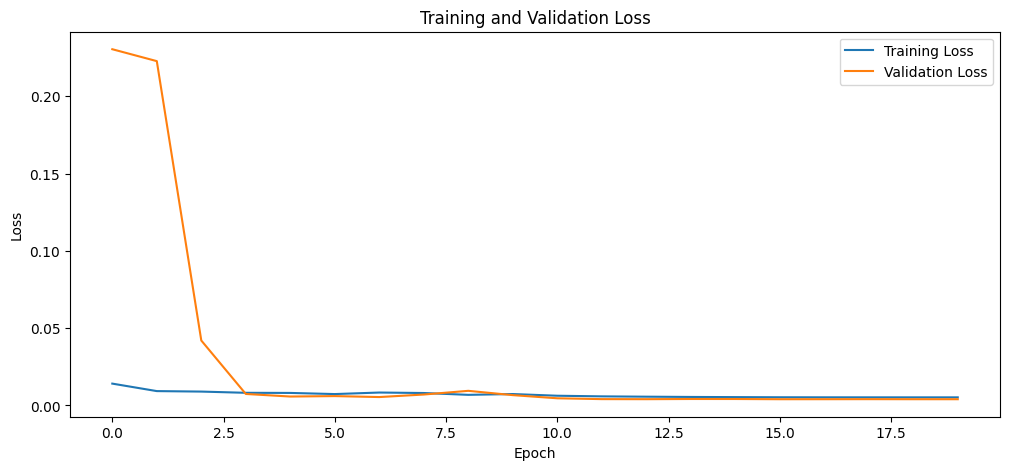

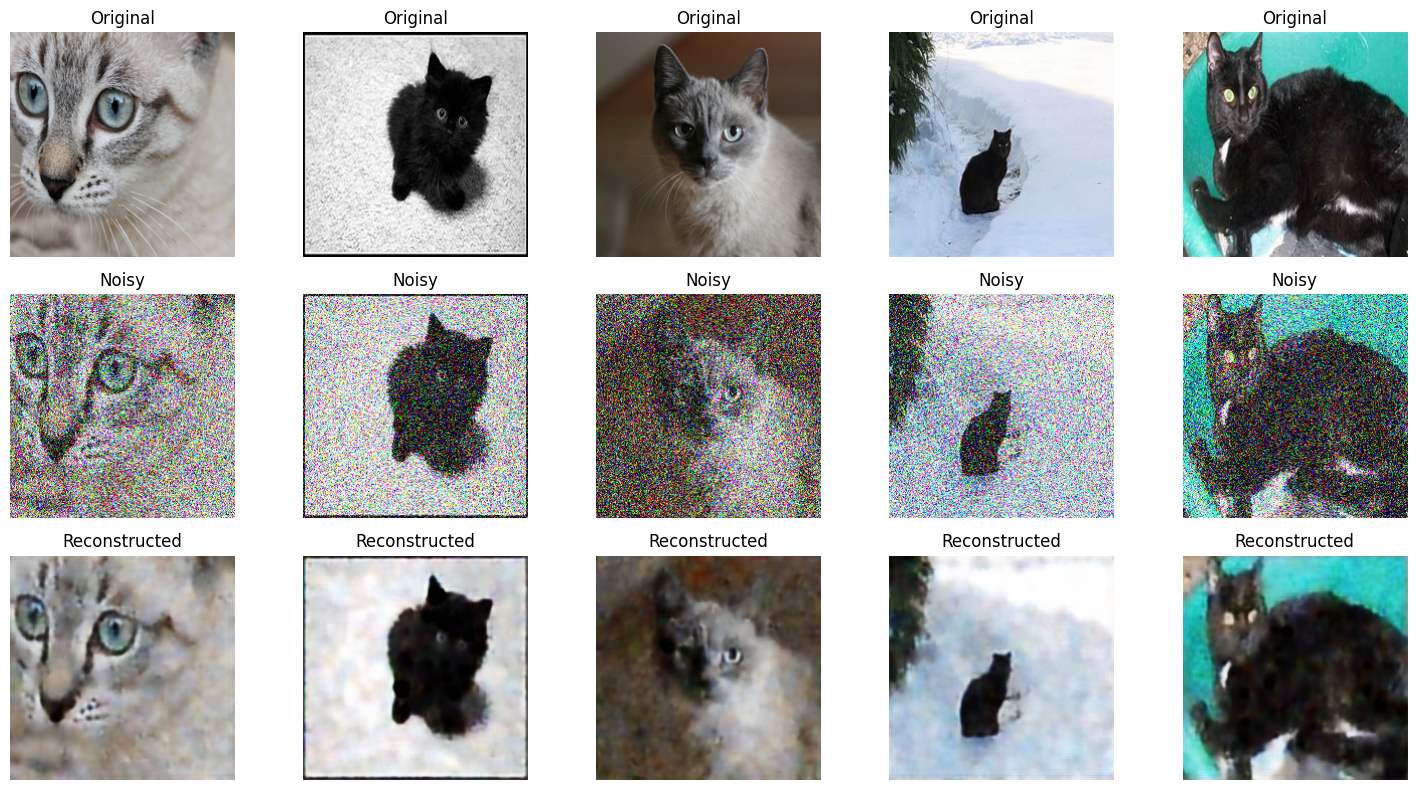

In [ ]:
def safe_psnr(original, reconstructed):
    try:
        return psnr(original, reconstructed, data_range=1.0)
    except:
        return float('nan')

def safe_ssim(original, reconstructed):
    try:
        return ssim(original, reconstructed, channel_axis=-1, data_range=1.0)
    except:
        return float('nan')

try:
    # Инициализация
    tf.keras.backend.clear_session()
    print("1. Загрузка данных...")
    data = MyDataset(DATA_DIR)
    print(f"   Загружено изображений: {len(data.image_paths)}")

    # Проверка данных
    print("\n2. Проверка данных...")
    sample_noisy, sample_original = next(iter(data.data_splits['train']))
    print(f"   Размер батча: {sample_noisy.shape}")
    print(f"   Диапазон значений: {sample_noisy.min():.2f}-{sample_noisy.max():.2f}")

    # Создание модели
    print("\n3. Создание модели...")
    autoencoder = create_autoencoder((IMG_HEIGHT, IMG_WIDTH, 3))
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    # Обучение
    print("\n4. Обучение модели...")
    history = autoencoder.fit(
        data.data_splits['train'],
        validation_data=data.data_splits['valid'],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
        ],
        verbose=1
    )

    # Получение тестовых данных
    test_noisy, test_original = next(iter(data.data_splits['test']))
    reconstructed = autoencoder.predict(test_noisy)

    # Оценка с обработкой ошибок
    test_noisy, test_original = next(iter(data.data_splits['test']))
    reconstructed = autoencoder.predict(test_noisy)

    psnr_values = [safe_psnr(o, r) for o, r in zip(test_original, reconstructed)]
    ssim_values = [safe_ssim(o, r) for o, r in zip(test_original, reconstructed)]

    # Фильтрация NaN значений
    psnr_val = np.nanmean(psnr_values)
    ssim_val = np.nanmean(ssim_values)

    print("\nРезультаты:")
    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}")

    # Визуализация графиков потерь на отдельной фигуре
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Визуализация изображений на отдельной фигуре
    plt.figure(figsize=(15, 8))
    n = 5  # Количество изображений для отображения
    for i in range(n):
        # Оригинальное изображение
        plt.subplot(3, n, i+1)
        plt.imshow(test_original[i])
        plt.title("Original")
        plt.axis('off')

        # Зашумленное изображение
        plt.subplot(3, n, i+n+1)
        plt.imshow(test_noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Восстановленное изображение
        plt.subplot(3, n, i+2*n+1)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nОшибка: {str(e)}")
    print("\nРекомендации:")
    print("1. Проверьте данные на корректность (нет ли битых изображений)")
    print("2. Уменьшите BATCH_SIZE до 4")
    print("3. Проверьте путь к данным:", DATA_DIR)
